In [1]:
# http://proceedings.mlr.press/v101/huang19a/huang19a.pdf
# https://www.researchgate.net/publication/220875351_Generative_Models_for_Labeling_Multi-object_Configurations_in_Images
# https://www.tensorflow.org/datasets/catalog/open_images_v4

In [2]:
%config Completer.use_jedi = False
from ipywidgets import IntProgress
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import logging
import tensorflow_datasets as tfds
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.mixture import GaussianMixture
import os

In [3]:
batch_size = 32
epochs = 10
dataset_name = 'cifar100'

In [4]:
train_ds,test_ds = tfds.load(name=dataset_name,split=['train', 'test']\
                                           ,as_supervised=False,download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar100-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar100-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /Users/mohamedbaddar/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [5]:
dims = [x['image'].get_shape().as_list() for x in train_ds]
dims_df= pd.DataFrame.from_records(data=dims,columns=['height','width','depth'])
dims_df.describe()

,height,width,depth
count,50000.0,50000.0,50000.0
mean,32.0,32.0,3.0
std,0.0,0.0,0.0
min,32.0,32.0,3.0
25%,32.0,32.0,3.0
50%,32.0,32.0,3.0
75%,32.0,32.0,3.0
max,32.0,32.0,3.0


In [6]:
height = 2**(int(np.log2(min(dims_df['height']))))
width = 2**(int(np.log2(min(dims_df['width']))))
height,width = min(height,width),min(height,width)
height,width

(32, 32)

In [7]:
train_ds = train_ds.map(lambda x: tf.image.resize(images=tf.cast(x['image'],dtype=tf.float32)/255.,\
                                                  size=[height,width]))
train_ds = train_ds.batch(batch_size,drop_remainder=True)
train_ds_double_zipped = tf.data.Dataset.zip(datasets=(train_ds,train_ds))

###
test_ds = test_ds.map(lambda x: tf.image.resize(tf.cast(x['image'],dtype=tf.float32)/255.,\
                                                size=[height,width]))
test_ds = test_ds.batch(batch_size,drop_remainder=True)
test_ds_double_zipped = tf.data.Dataset.zip(datasets=(test_ds,test_ds))

###
# validation_ds = validation_ds.map(lambda x: tf.image.resize(tf.cast(x['image'],dtype=tf.float32)/255.\
#                                                             ,size=[height,width]))
# validation_ds = validation_ds.batch(batch_size,drop_remainder=True)
# validation_ds_double_zipped = tf.data.Dataset.zip(datasets=(validation_ds,validation_ds))


In [8]:
# just to detect the dimension distribution
# dims = [x.get_shape().as_list() for x in train_ds]
# dims_df= pd.DataFrame.from_records(data=dims,columns=['batch','height','width','depth'])
# dims_df.describe()

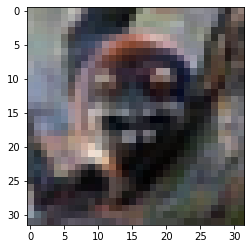

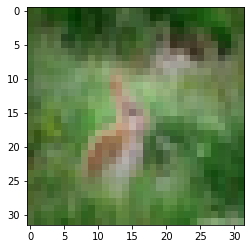

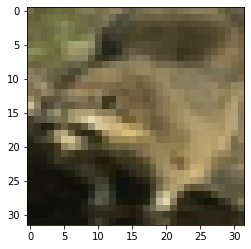

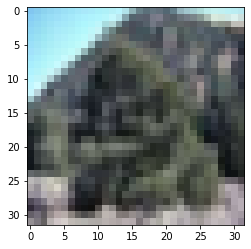

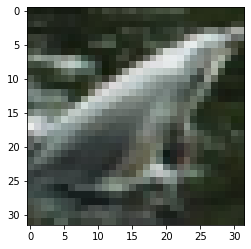

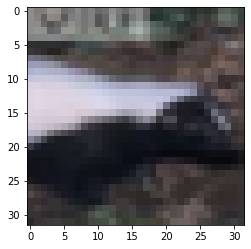

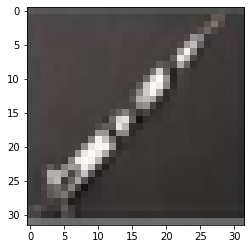

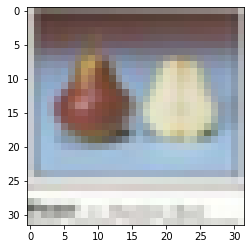

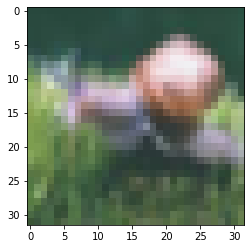

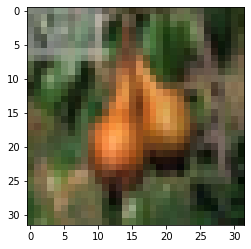

In [9]:
for e in train_ds.take(10):
    plt.imshow(e[0].numpy())
    plt.show()

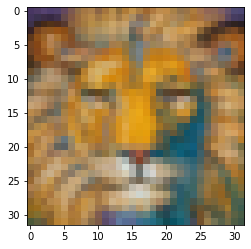

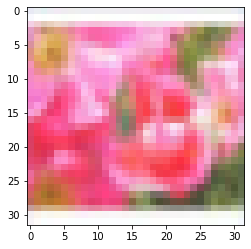

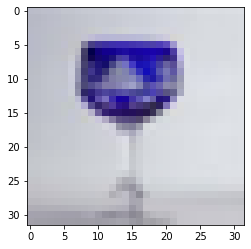

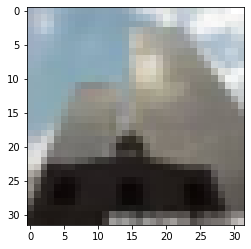

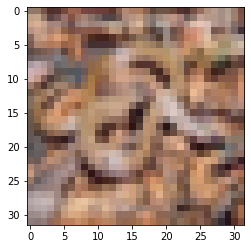

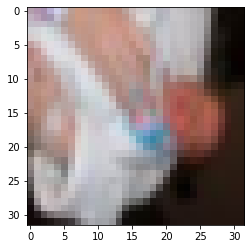

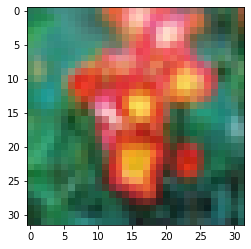

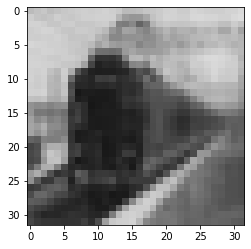

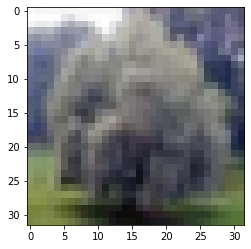

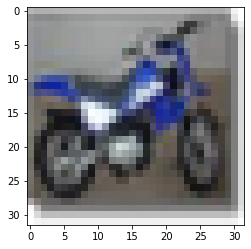

In [10]:
for e in test_ds.take(10):
    plt.imshow(e[0].numpy())
    plt.show()

In [15]:
latent_dim = 4096
batch_size = 32
class CAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CAE, self).__init__()
        self.latent_dim = latent_dim
        self.logger = logging.getLogger('CAE')
        self.encoder = tf.keras.Sequential(name='encoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(height, width, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(name='decoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=int(height/4) * int(width/4) * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(int(height/4), int(width/4), 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )

        self.encoder.summary()
        self.decoder.summary()
        
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


cae = CAE(latent_dim)
cae.compile(optimizer='adam', loss=losses.MeanSquaredError())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              8390656   
______________________________

In [16]:
model_file_path = f'./models/cae_dataset_{dataset_name}_z_dim_{latent_dim}'
print(f'model path = {model_file_path}')

model path = ./models/cae_dataset_cifar100_z_dim_4096


In [17]:

if os.path.exists(model_file_path):
    print('loading saved model')
    cae = tf.keras.models.load_model(filepath=model_file_path)
else:
    print('building model')
    cae.fit(x=train_ds_double_zipped,validation_data=test_ds_double_zipped,epochs=10)
    print('saving model')
    cae.save(filepath=model_file_path)

building model
Epoch 1/10
1562/1562 [==============================] - 150s 96ms/step - loss: 0.0219 - val_loss: 0.0048
Epoch 2/10
1562/1562 [==============================] - 151s 96ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 3/10
1562/1562 [==============================] - 154s 99ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 4/10
1562/1562 [==============================] - 156s 100ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 5/10
1562/1562 [==============================] - 154s 98ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/10
1562/1562 [==============================] - 161s 103ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/10
1562/1562 [==============================] - 147s 94ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/10
1562/1562 [==============================] - 476s 305ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/10
1562/1562 [==============================] - 161s 103ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/10
1562/1562 [=============

INFO:tensorflow:Assets written to: ./models/cae_dataset_cifar100_z_dim_4096/assets


In [18]:
z_tensor = None

inf_or_unknown_cardinality = ((test_ds.cardinality()==tf.data.INFINITE_CARDINALITY)\
    or (test_ds.cardinality() == tf.data.UNKNOWN_CARDINALITY)).numpy()
batches = test_ds.cardinality().numpy() if not inf_or_unknown_cardinality else 500

with tqdm(total=batches) as pbar:
    for batch in test_ds.take(batches):
        z = cae.encoder(batch).numpy()
        if z_tensor is None:
            z_tensor = tf.convert_to_tensor(z)
        else:
            z_tensor = tf.concat([z_tensor,tf.convert_to_tensor(z)],axis=0)
        pbar.update(1)
        #print(f'z shape {z.shape}')
        decoded_imgs = cae.decoder(z).numpy()
        #print(f'decoded images shape {decoded_imgs[0].shape}')
        #plt.imshow(batch[0])
        #plt.show()
        #plt.imshow(decoded_imgs[0])
        #plt.show()
z_tensor.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/312 [00:00<?, ?it/s]

TensorShape([9984, 4096])

In [19]:
z_np= z_tensor.numpy()
n_z = z_np.shape[0]
n_z_train = int(0.8*n_z)
z_train = z_np[:n_z_train]
z_test = z_np[n_z_train:]

In [20]:
print(f"""For Dateset "{dataset_name}" Calculating relative difference of log likelihood  """)
print('############################  ')
g_fit = GaussianMixture(n_components=1,covariance_type='diag').fit(z_train)
logp_g = g_fit.score(X=z_test)
for k in [10,20,50,70,100,200]:
    try:
        gm_fit = GaussianMixture(n_components=k,covariance_type='diag').fit(z_train)
        logp_gm = gm_fit.score(X=z_test)

        rel_diff_logps = (logp_gm- logp_g) / np.abs(logp_g)
        print(f'logp Gaussin Mixture with k = {k} = {logp_gm}  ')
        print(f'logp Gaussian Diagonal = {logp_g}  ')
        print(f'At k = {k} , rel_diff for logps = {rel_diff_logps}  ')
        print('##############  ')
    except Exception as e:
        print(f'Catched expection {e}  ')

For Dateset "cifar100" Calculating relative difference of log likelihood  
############################  
logp Gaussin Mixture with k = 10 = 4348.738804362613  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 10 , rel_diff for logps = 0.07647131016925454  
##############  
logp Gaussin Mixture with k = 20 = 4384.332721210587  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 20 , rel_diff for logps = 0.08528210153362795  
##############  
logp Gaussin Mixture with k = 50 = 4422.78147918955  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 50 , rel_diff for logps = 0.09479957010048548  
##############  
logp Gaussin Mixture with k = 70 = 4428.119142994677  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 70 , rel_diff for logps = 0.09612083638205283  
##############  
logp Gaussin Mixture with k = 100 = 4425.925444793071  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 100 , rel_diff for logps = 0.09557781614482229  
##############  
logp Gaussin Mixture with k 

## Results

**For dataset VOC**

For Dateset VOC Calculating relative difference of log likelihood  
############################  
logp Gaussin Mixture with k = 10 = 3239.302399019124  
logp Gaussian Diagonal = 2790.16976645871  
At k = 10 , rel_diff for logps = 0.16096964348174925  
##############  
logp Gaussin Mixture with k = 20 = 3334.117578802105  
logp Gaussian Diagonal = 2790.16976645871  
At k = 20 , rel_diff for logps = 0.19495151115259016  
##############  
logp Gaussin Mixture with k = 50 = 3411.8171131494596  
logp Gaussian Diagonal = 2790.16976645871  
At k = 50 , rel_diff for logps = 0.22279911214138984  
##############  
logp Gaussin Mixture with k = 70 = 3429.9682203595194  
logp Gaussian Diagonal = 2790.16976645871  
At k = 70 , rel_diff for logps = 0.22930448949450236  
##############  
logp Gaussin Mixture with k = 100 = 3428.6442835155385  
logp Gaussian Diagonal = 2790.16976645871  
At k = 100 , rel_diff for logps = 0.22882998903223795  
##############  
logp Gaussin Mixture with k = 200 = 3415.867706729245  
logp Gaussian Diagonal = 2790.16976645871  
At k = 200 , rel_diff for logps = 0.22425084946163418  
##############  

**For dataset wider_face**
For Dateset wider_face Calculating relative difference of log likelihood  
############################  
logp Gaussin Mixture with k = 10 = 1726.1243177708377  
logp Gaussian Diagonal = 1561.8860242887904  
At k = 10 , rel_diff for logps = 0.10515382744194393  
##############  
logp Gaussin Mixture with k = 20 = 1751.7959812169918  
logp Gaussian Diagonal = 1561.8860242887904  
At k = 20 , rel_diff for logps = 0.1215901506095347  
##############  
logp Gaussin Mixture with k = 50 = 1776.35932923814  
logp Gaussian Diagonal = 1561.8860242887904  
At k = 50 , rel_diff for logps = 0.13731687307145898  
##############  
Catched expection Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.  
Catched expection Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.  
Catched expection Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.  



For Dateset "mnist" Calculating relative difference of log likelihood  
############################  
logp Gaussin Mixture with k = 10 = 7841.956234385311  
logp Gaussian Diagonal = 7377.442821602376  
At k = 10 , rel_diff for logps = 0.06296401395653828  
##############  
logp Gaussin Mixture with k = 20 = 7988.197403977028  
logp Gaussian Diagonal = 7377.442821602376  
At k = 20 , rel_diff for logps = 0.08278675919876485  
##############  
logp Gaussin Mixture with k = 50 = 8243.583374395243  
logp Gaussian Diagonal = 7377.442821602376  
At k = 50 , rel_diff for logps = 0.11740389912025657  
##############  
logp Gaussin Mixture with k = 70 = 8305.125097353703  
logp Gaussian Diagonal = 7377.442821602376  
At k = 70 , rel_diff for logps = 0.12574577644098017  
##############  
logp Gaussin Mixture with k = 100 = 8385.913961674707  
logp Gaussian Diagonal = 7377.442821602376  
At k = 100 , rel_diff for logps = 0.1366965714894272  
##############  
logp Gaussin Mixture with k = 200 = 8500.999476912375  
logp Gaussian Diagonal = 7377.442821602376  
At k = 200 , rel_diff for logps = 0.15229622004253812  
##############  

For Dateset "cifar100" Calculating relative difference of log likelihood  
############################  
logp Gaussin Mixture with k = 10 = 4348.738804362613  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 10 , rel_diff for logps = 0.07647131016925454  
##############  
logp Gaussin Mixture with k = 20 = 4384.332721210587  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 20 , rel_diff for logps = 0.08528210153362795  
##############  
logp Gaussin Mixture with k = 50 = 4422.78147918955  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 50 , rel_diff for logps = 0.09479957010048548  
##############  
logp Gaussin Mixture with k = 70 = 4428.119142994677  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 70 , rel_diff for logps = 0.09612083638205283  
##############  
logp Gaussin Mixture with k = 100 = 4425.925444793071  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 100 , rel_diff for logps = 0.09557781614482229  
##############  
logp Gaussin Mixture with k = 200 = 4424.68448280697  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 200 , rel_diff for logps = 0.09527063283601832  
##############  